In [12]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [13]:
#initialize the dataframe with 1980 data
since_1980_df = pd.DataFrame()
since_1980_df = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/1980/1980.csv')

# add additional years
for year in range(1981,2016):
    url = 'http://wichita.ogs.ou.edu/eq/catalog/' + str(year) + '/' + str(year) + '.csv'
    temp_df = pd.read_csv(url)
    # This might not be the most efficient method
    since_1980_df = since_1980_df.append(temp_df)
since_1980_df.head()

,id,origintime,latitude,longitude,depth,err_lon,err_lat,err_depth,err_origintime,county,origin_src,prefmag,pmag_type,pmag_src,mw,mw_src,mblg_ogs,mblg_usgs,ml_ogs,m3hz_ogs,md_ogs,mb,ms,mfa,max_mmi,reafile,reamtime,geom,pdlid,mw_ogs
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,NaN,NaN,NaN,NaN,CANADIAN,OGS,1.9,M3Hz,OGS,NaN,NaN,1.6,NaN,NaN,1.9,1.7,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,NaN,NaN
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,NaN,NaN,NaN,NaN,GARFIELD,OGS,1.7,M3Hz,OGS,NaN,NaN,NaN,NaN,NaN,1.7,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000000C022B87166958C0448B6CE7FB39...,NaN,NaN
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.2,M3Hz,OGS,NaN,NaN,1.9,NaN,NaN,2.2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,NaN,NaN
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,NaN,NaN,NaN,NaN,LOVE,OGS,2.1,M3Hz,OGS,NaN,NaN,2.3,NaN,NaN,2.1,1.9,NaN,NaN,NaN,3,NaN,NaN,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,NaN,NaN
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,NaN,NaN,NaN,NaN,HASKELL,OGS,1.2,M3Hz,OGS,NaN,NaN,1.4,NaN,NaN,1.2,1.4,NaN,NaN,NaN,NaN,NaN,NaN,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,NaN,NaN


In [14]:
#Add column for year
years = []
for time in since_1980_df['origintime']:
    year = int(str.split(time, '-')[0])
    years.append(year)
    #index = time.key
year_column = pd.Series(years, index=since_1980_df.index)
since_1980_df['year'] = year_column
since_1980_df.head()
year_column.unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015])

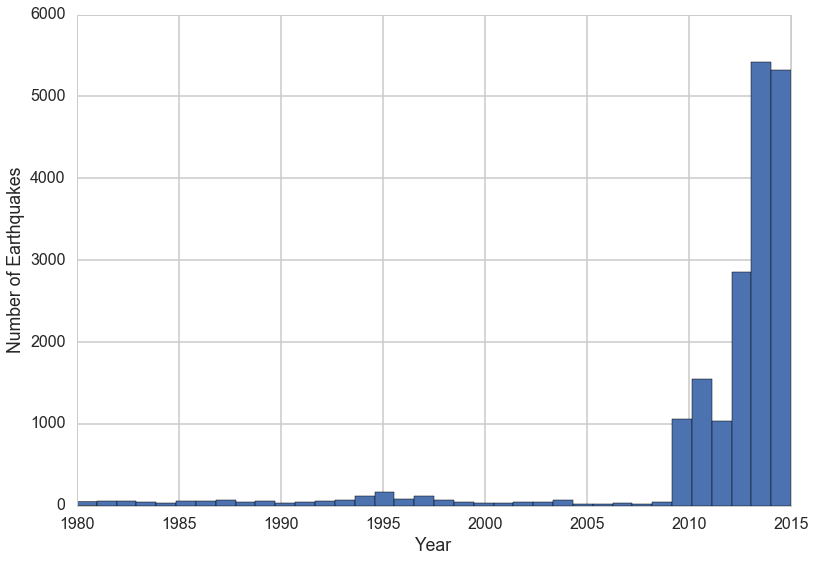

In [15]:
#plot number of earthquakes by year
plt.hist(since_1980_df['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

In [16]:
#UNKNOWN ERROR ATTEMPTING TO DUMP AND LOAD AGAIN, 
#FEEL FREE TO ADD THE FUNCTION, PERHAPS YOU WILL HAVE BETTER LUCK

In [33]:
#DISTANCE FUNCTION
#FOR CALCULATING DISTANCE TO FRACKING SITES, 
#DISTANCE FROM ONE EARTHQUAKE SITE TO THE NEXT, ETC.

#function taken from http://www.johndcook.com/blog/python_longitude_latitude/
#assumes that earth is perfectly spherical
import math

#in kilometers
def distancef(lat1, long1, lat2, long2, earth_radius=6371):
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )
    
    distance=earth_radius*arc
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return distance

In [35]:
#EXAMPLE OF FUNCTION IN USE
distance = distancef(since_1980_df.iloc[15749]['latitude'], 
                     since_1980_df.iloc[15749]['longitude'], 
                     since_1980_df.iloc[15750]['latitude'], 
                     since_1980_df.iloc[15750]['longitude'])
distance

131.9769916951462

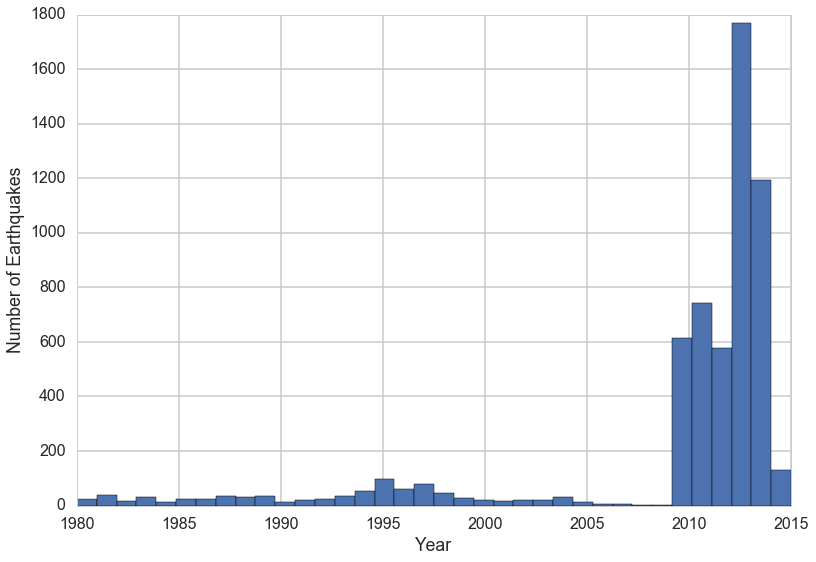

In [30]:
#Earthquakes <2 magnitude
#mask for earthquakes >2 magnitude
l2mask = since_1980_df['prefmag'] <2
plt.hist(since_1980_df[l2mask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

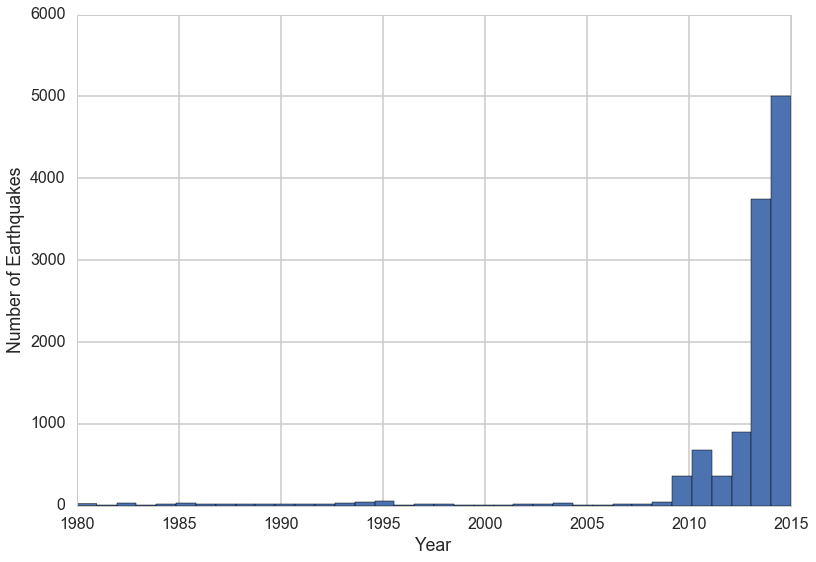

In [36]:
#Earthquakes 2>magnitude<4
#mask for earthquakes >2 magnitude
b24mask = (since_1980_df['prefmag'] >2) & (since_1980_df['prefmag'] < 4)
plt.hist(since_1980_df[b24mask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

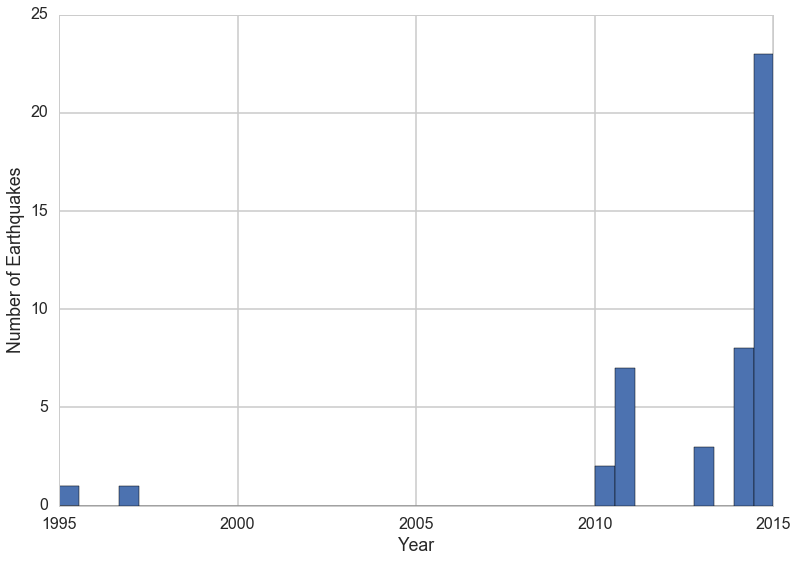

In [37]:
#Earthquakes >4 magnitude
#mask for earthquakes >4 magnitude
gfmask = since_1980_df['prefmag'] >4
plt.hist(since_1980_df[gfmask]['year'].values, bins=2015-1980+1)
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')

In [43]:
#REQUIRES INSTALLATION conda install basemap
#received assistance from https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
def plot_earthquakes(df, minyr, maxyr):
    mask = df.year>=minyr & df.year<=maxyr
    map = Basemap(llcrnrlon=int(min(df.longitude))-10, llcrnrlat=int(min(df.latitude))-5,
                  urcrnrlon=int(max(df.longitude))+10, urcrnrlat=int(max(df.latitude))+5)
    """
    min_marker_size = 4
    for lon, lat, mag in zip(df.longitude.values, df.latitude.values, df.prefmag.values):
        x,y = map(lon, lat)
        msize = mag * min_marker_size
        map.plot(x, y, 'ro', markersize=msize)
    """
    #map.plot(df.longitude.values, df.latitude.values, 'ro', markersize=2)
    map.drawmapboundary(fill_color='white')
    map.drawcoastlines()
    map.drawstates()
    plt.show()

In [44]:
#TESTING
plot_earthquakes(since_1980_df,1980,1990)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [53]:
#converts time stamp to day, hour
#Jan 1 of start year is day 1
#def to_hours(startyear,df):
import time
# We collect the time of each event
#year_day = []
#for date in df.origintime.values:
    #new_date = time.strptime(date, "%Y/%m/%d %H:%M:%S")
    #year_day.append(new_date.tm_yday)    
# Group earthquakes by day in 2015
#df['year_day'] = year_day
#df_byYear = df.groupby('year_day')
    
#test = time.strptime(since_1980_df.origintime[0], "%Y/%m/%d %H:%M:%S")
#test
date = since_1980_df.iloc[15749]['origintime']
date
#new_date = time.strptime(date, "%Y-%m-%d %H:%M:%S")
#new_date

'2015-05-04 12:17:16.798999'